<h1><center>Temperature Changes in the Gulf of Maine</center></h1>

<center>Here I'll look at some long term trends in surface temperature in the Gulf of Main (GoM). This is related to a project Al Wanamaker- a colleague of Caroline's- is leading to explore the onset of climate change in the GoM.</center>

***


In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
from IPython.display import clear_output
from IPython.display import display, HTML
from scipy import stats

%run /home/ncresswell/Desktop/AzoresHigh_850-2005/MyFunctions/DataAnalyzing.py

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

<center>I'm looking at a period from 1650 to present day; the CESM LME simulation should be appropriate for this. Below, I'll load the data</center>

In [2]:
#lat and lon are saved in cesm_lme folder
lat = np.load('/data/ncresswell/cesm-cam5-lme/lat.npy')
lon = np.load('/data/ncresswell/cesm-cam5-lme/lon.npy')

#initialize array to hold surface temperature for all ensemble members 
surf_temp = np.empty([12,13872,96,144])

#loop reads in one ensemble member at a time
for i in range(2,14):
    
    #define the filename for the current ensemble member
    if i<10:
        ensemble_member = '00'+str(i)
    else:
        ensemble_member = '0'+str(i)
    filename = '/climodes/data3/datasets/ucar/cesm1-cam5-lme/t/b.e11.BLMTRC5CN.f19_g16.'+ensemble_member+'.cam.h0.T.*.nc'
    
    surf_temp[i-2,:,:,:] = xr.open_mfdataset(filename)['T'][:,-1,:,:].values
    
    #keep up with progress
    clear_output()
    print(str(i)+' of 13')
    

13 of 13


<center>Next, I need to identify exactly where I'd like to observe the surface temperature. I'll use cartopy projections to identify the GoM and then isolate it.</center>

In [3]:
test_data = surf_temp.mean(axis=0).mean(axis=0)

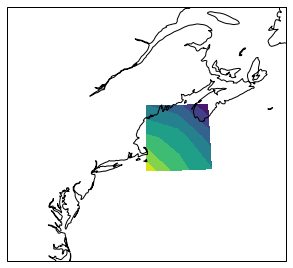

In [4]:
####################################     TRYING OUT FILTERS     ################################

lat1 = 69# <-----These are not the actual lat and lon, they represent indices within the 
lat2 = 72#       lat and lon arrays
lon1 = 43
lon2 = 46

filter_latlon = np.ones([96,144])*np.nan
filter_latlon[lat1:lat2,lon1:lon2]=np.ones(filter_latlon[lat1:lat2,lon1:lon2].shape)

new_data = test_data*filter_latlon

####################################   PLOTTING FILTERED DATA   ################################

fig, ax = plt.subplots(figsize=(5,5))

ax = plt.subplot(projection=ccrs.Orthographic(central_latitude=40,central_longitude=-70))
ax.coastlines(resolution='50m')
ax.set_extent([-80,-60,35,50])
ax.contourf(lon,lat,new_data,transform=ccrs.PlateCarree());


<center>Now I average over this region at each time step to acheive a time series for each ensemble member of the monthly surface temperature over the GoM</center>

In [5]:
surf_temp_GoM = surf_temp[:,:,lat1:lat2,lon1:lon2].mean(axis=2).mean(axis=2)

<center>In the study, Al Wanamaker uses 12 month periods and so I'll take yearly averages.</center>

In [6]:
surf_temp_GoM_yearly = surf_temp_GoM.reshape([12,1156,12]).mean(axis=2)


surf_temp_GoM_yearly = surf_temp_GoM_yearly[:,750:]# <-----we're only concerned with 1600 and on (time[750]==1600)

<center>Now, I'll plot the ensemble mean...</center>

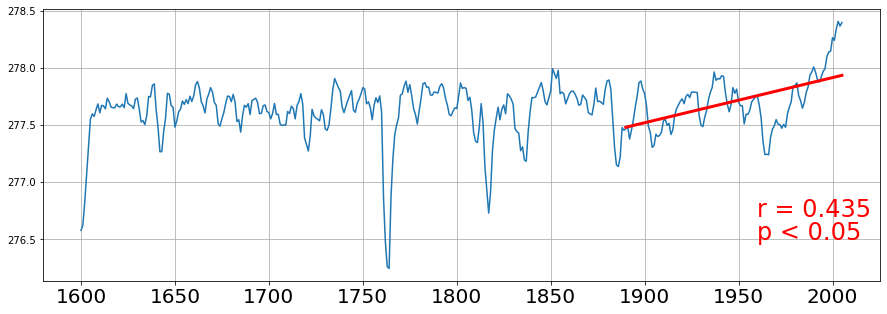

In [7]:
#calculate regression for the time period in question
slop,intercept, r_value, p_value, std_err = stats.linregress(np.arange(290,406),surf_temp_GoM_yearly.mean(axis=0)[290:])
regression = [slop*i+intercept for i in np.arange(290,406)]

#plot mean time series and regression during last 116 years (1890 to 2006)
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(running_average(surf_temp_GoM_yearly.mean(axis=0),window=5))
ax.set_xticklabels(ax.get_xticks().astype(int)+1600,fontsize=20);
ax.plot(np.arange(290,406), regression, 'r',linewidth=3);
ax.grid()

ax.text(360,276.7,'r = '+str(np.around(r_value,3)),fontsize=24,c='red')
if p_value<.05:                                        
    ax.text(360,276.5,'p < 0.05',fontsize=24,c='red')#<-----determine on the confidence level
elif p_value<.1:
    ax.text(360,276.5,'p < 0.1',fontsize=24,c='red')


<center>...and individual ensemble members</center>

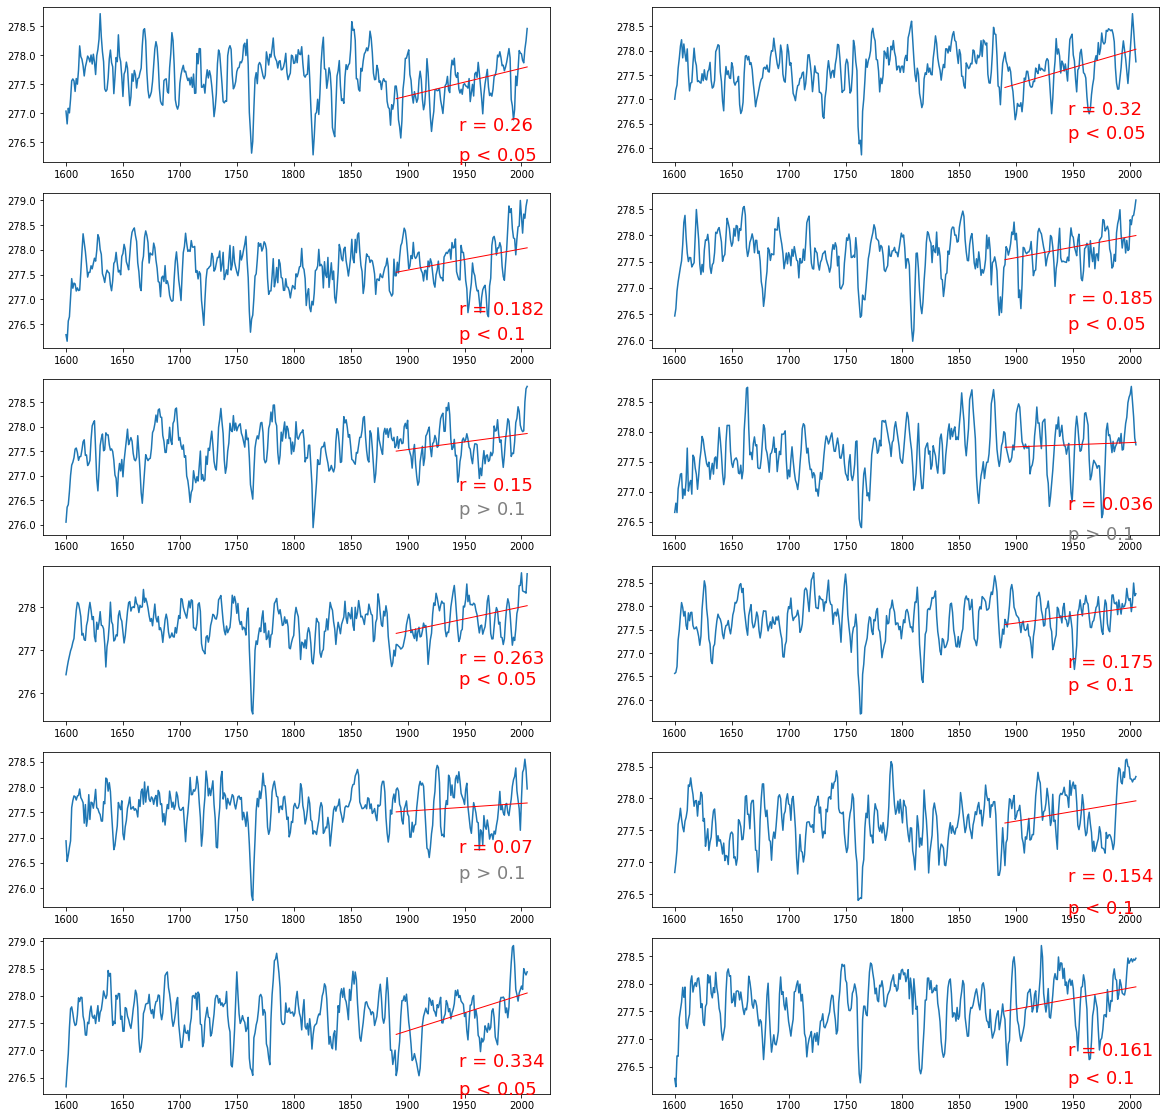

In [323]:
fig, axs = plt.subplots(ncols=2,nrows=6,figsize=(20,20))

ensemble_member = 0# <------START ENSEMBLE MEMBER COUNTER

for row in range(0,6):
    for col in range(0,2):  
        
        #plot smoothed data
        axs[row,col].plot(running_average(surf_temp_GoM_yearly[ensemble_member,:],window=5))
        axs[row,col].set_xticklabels(axs[row,col].get_xticks().astype(int)+1600,fontsize=10);
        
        #calculate and plot regression for the time period in question
        slop,intercept, r_value, p_value, std_err = stats.linregress(np.arange(290,406),surf_temp_GoM_yearly[ensemble_member][290:])
        regression = [slop*i+intercept for i in np.arange(290,406)] 
        
        axs[row,col].plot(np.arange(290,406), regression, 'r',linewidth=1);
        axs[row,col].text(345,276.7,'r = '+str(np.around(r_value,3)),fontsize=18,c='red')
        if p_value<.05:
            axs[row,col].text(345,276.2,'p < 0.05',fontsize=18,c='red')
        elif p_value<.1:
            axs[row,col].text(345,276.2,'p < 0.1',fontsize=18,c='red')
        else:
            axs[row,col].text(345,276.2,'p > 0.1',fontsize=18,c='grey')
            
        #increment ensemble member
        ensemble_member=ensemble_member+1